# Data Preparation

In [1]:
import pandas as pd
%matplotlib inline
from functools import reduce
import datetime

Matplotlib is building the font cache; this may take a moment.


In [0]:
DATA_PATH='/data/workspace_files/iqvia_data/'

files_claims = ['claims_2015.dat','claims_2016.dat', 'claims_2017.dat', 'claims_2018.dat', 'claims_2019.dat']
files_lookup = {
    'enroll':{'file':'enroll_synth.dat', 'key':'pat_id'},
    'enroll2':{'file':'enroll2.dat', 'key':'pat_id'},
    'dx_lookup':{'file':'pp_dx_lookup.dat', 'key':'dx_cd'},
    'pos_lookup':{'file':'pp_pos_lookup.dat', 'key':'place_of_svc_cd'},
    'pr_lookup':{'file':'pp_pr_lookup.dat', 'key':'procedure_cd'},
    'rev_lookup':{'file':'pp_rev_lookup.dat', 'key':'rev_cd'},
    'rx_lookup':{'file':'pp_rx_lookup.dat', 'key':'ndc'}}
selected_columns = ['pat_id', 'rectype', 'pos', 'conf_num', 'ndc', 'formulary', 'quan', 'proc_cde'
                   , 'from_dt', 'to_dt'
                    , 'diag_admit', 'diag1', 'diag2', 'diag3', 'diag4', 'diag5', 'diag6'
                    , 'diag7', 'diag8', 'diag9', 'diag10', 'diag11', 'diag12'
                    , 'icdprc1', 'icdprc2', 'icdprc3', 'icdprc4', 'icdprc5', 'icdprc6'
                    , 'icdprc7', 'icdprc8', 'icdprc9', 'icdprc10', 'icdprc11', 'icdprc12'
                    , 'paid', 'copay', 'dispense_fee', 'bill_spec'
                   , 'prscbr_spec', 'pmt_st_cd', 'paid_dt']
group_by_columns = ['pat_id', 'from_dt', 'to_dt', 'rectype', 'conf_num'
                    , 'diag_admit', 'diag1', 'diag2', 'diag3', 'diag4', 'diag5', 'diag6'
                    , 'diag7', 'diag8', 'diag9', 'diag10', 'diag11', 'diag12'
                    , 'icdprc1', 'icdprc2', 'icdprc3', 'icdprc4', 'icdprc5', 'icdprc6'
                    , 'icdprc7', 'icdprc8', 'icdprc9', 'icdprc10', 'icdprc11', 'icdprc12'
                    , 'proc_cde', 'bill_spec', 'pos', 'ndc', 'quan'
                    ,'formulary', 'paid_dt', 'pmt_st_cd']
date_columns = ['from_dt', 'to_dt', 'paid_dt']
numerical_columns = ['quan', 'paid', 'copay', 'dispense_fee']
e_selected_columns = ['der_sex', 'der_yob', 'pat_id', 'pat_state']
e2_selected_columns = ['pat_id', 'mh_cd']
claims_dtype = {}
for column in selected_columns:
    if column in date_columns:
        claims_dtype[column] = 'object'
    elif column in numerical_columns:
        claims_dtype[column] = 'float64'
    else:
        claims_dtype[column] = 'str'

In [0]:
def custom_fill_na(dataframe):
    for col in dataframe:
        dt = dataframe[col].dtype 
        if dt == int or dt == float:
            dataframe[col].fillna(0, inplace=True)
        else:
            dataframe[col].fillna("-", inplace=True)

def load_data(files):
    _data = pd.DataFrame()
    for file in files:
        print(f'Loading {file}')
        _data = _data.append(pd.read_table(DATA_PATH+file, delimiter="|", usecols = selected_columns, dtype = claims_dtype)) 
    custom_fill_na(_data)        
    # Aggregate dataset
    _data = _data.groupby(group_by_columns).sum().reset_index()
    # Assign Datetime      
    for _column in date_columns: 
        _data[_column] = pd.to_datetime(_data[_column])

    return _data

## Load 2015 & 2016 Data
- We're only loading 2015 and 2016 data
- Aggregate the data to the desired level 

In [0]:
'''
Only loading 2015 and 2016 data
'''
combined_data = load_data(files_claims[0:2])

## Cleanup & Enrichment
- Join to Enroll, DX_Lookup, POS_Lookup, REV_Lookup to get additional relevant features
- Remove records for which the lookup values are not available
- Add additional features <<Age Group, Duration of stay>>

In [0]:

#Join with enroll to get patient demographic data 
enroll = pd.read_table(DATA_PATH+files_lookup['enroll']['file'],delimiter="|", usecols = e_selected_columns)

data_frames = [combined_data, enroll]
combined_data = reduce(lambda  left,right: pd.merge(left,right,on=['pat_id'],how='inner'), data_frames)


### Derived Features

In [0]:

''' 
We only want the values that are available in the lookup
'''
dx_lookup = pd.read_table(DATA_PATH+files_lookup['dx_lookup']['file'],delimiter="|")
pos_lookup = pd.read_table(DATA_PATH+files_lookup['pos_lookup']['file'],delimiter="|")
pr_lookup = pd.read_table(DATA_PATH+files_lookup['pr_lookup']['file'],delimiter="|")
# rev_lookup = pd.read_table(DATA_PATH+files_lookup['rev_lookup']['file'],delimiter="|")

dx_key = files_lookup['dx_lookup']['key']
pos_key = files_lookup['pos_lookup']['key'] 
pr_key = files_lookup['pr_lookup']['key'] 
# rev_key = files_lookup['rev_lookup']['key'] 

combined_data = combined_data[(combined_data['diag1'].isin(dx_lookup[dx_key])) | (combined_data['diag1']=="-")]
combined_data = combined_data[(combined_data['diag_admit'].isin(dx_lookup[dx_key])) | (combined_data['diag_admit']=="-")]
combined_data = combined_data[(combined_data['proc_cde'].isin(pr_lookup[pr_key])) | (combined_data['proc_cde']=="-")]
# combined_data[(combined_data['pos'].isin(pos_lookup[pos_key])) | (combined_data['pos']=="")]



In [0]:
# combined_data['quarter'] = combined_data['to_dt'].dt.to_period("Q")
combined_data['quarter'] = combined_data['to_dt'].dt.quarter
combined_data['quarter'] = combined_data['quarter'].astype(str)

# Duration - The length of stay, we will group them into buckets
combined_data['duration'] = combined_data['to_dt'] - combined_data['from_dt']

# Set is_inpatient to 1 if the duration is more than 0
combined_data.loc[combined_data['duration'] == datetime.timedelta(days=0), 'is_in_patient'] = 0
combined_data.loc[combined_data['duration'] > datetime.timedelta(days=0), 'is_in_patient'] = 1
combined_data['is_in_patient'] = combined_data['is_in_patient'].astype(str)


# Age & Age Group - Age is deried from To date and Patient DOB if available
combined_data['pat_age'] = combined_data['to_dt'].dt.year - combined_data['der_yob']
pat_age_bins= [0,10,20,30,40,50,60,70,80,150]
pat_age_groups = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81 >']
combined_data['age_group'] = pd.cut(combined_data['pat_age'], bins=pat_age_bins, labels=pat_age_groups, right=False)
combined_data['age_group'] = combined_data['age_group'].astype('str')

# Calculate duration of stay
duration_bins= [pd.Timedelta(days = 0),
                pd.Timedelta(days = 7),
                pd.Timedelta(days = 15),
                pd.Timedelta(days = 30),
                pd.Timedelta(days = 60),
                pd.Timedelta(days = 5000)]
duration_groups = ['<7', '8-15', '16-30', '31-60', '60>']
combined_data['duration'] = pd.cut(combined_data['duration'], bins=duration_bins, labels=duration_groups, right=False)
combined_data['duration'] = combined_data['duration'].astype('str')

In [0]:
diag_columns = ['diag1', 'diag2', 'diag3', 'diag4', 'diag5', 'diag6'
                    , 'diag7', 'diag8', 'diag9', 'diag10', 'diag11', 'diag12']
icdprc_columns = ['icdprc1', 'icdprc2', 'icdprc3', 'icdprc4', 'icdprc5', 'icdprc6'
                    , 'icdprc7', 'icdprc8', 'icdprc9', 'icdprc10', 'icdprc11', 'icdprc12']
                    
# Add two new columns to get the count of diagnosis and procedure codes 
combined_data['count_of_diag'] = (combined_data[diag_columns] != "-").sum(axis=1)
combined_data['count_of_icdprc'] = (combined_data[icdprc_columns] != "-").sum(axis=1)


# Create a column that represents the total cost = paid + copay + dispense_fee
target_columns = ['paid', 'copay', 'dispense_fee']
combined_data['target'] = (combined_data.loc[:, target_columns]).sum(axis='columns')

#Handle nulls
custom_fill_na(combined_data)

In [0]:
# Setup Column order for easier readability
output_columns = ['pat_id', 'quarter','from_dt', 'to_dt', 'is_in_patient','duration', 'paid_dt', 'rectype', 'conf_num', 'icdprc1',
       'diag_admit', 'diag1', 'count_of_diag','proc_cde', 'count_of_icdprc','ndc', 'bill_spec', 'pos','der_sex', 'der_yob', 'pat_state',  'pat_age',
       'age_group', 'quan', 'formulary',  'pmt_st_cd', 'paid', 'copay', 'dispense_fee', 'target']

In [0]:
combined_data.columns, combined_data.shape

In [0]:
combined_data[output_columns]

## Load to CSV (To avoid rerunning Data Prep)

In [0]:
combined_data[output_columns].to_csv(DATA_PATH+'clean/model_input.csv', sep='|')

# Data Analysis

In [0]:
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import dataprep
from dataprep.eda import create_report
from dataprep.eda import plot, plot_correlation
import warnings
warnings.filterwarnings('ignore')

# Analyze CLaims file

In [0]:
claims_2015 = pd.read_csv('/data/workspace_files/iqvia_data/claims_2015.dat', delimiter="|")

In [0]:
dataprep.eda.plot(claims_2015)

In [0]:
dataprep.eda.plot_correlation(claims_2015)

## Load and Analyze Aggregated Data

In [0]:
DATA_PATH='/data/workspace_files/iqvia_data/clean/model_input.csv'

input_columns = ['pat_id', 'quarter','from_dt', 'to_dt', 'is_in_patient','duration', 'paid_dt', 'rectype', 'conf_num', 'icdprc1',
       'diag_admit', 'diag1', 'count_of_diag','proc_cde', 'count_of_icdprc','ndc', 'bill_spec', 'pos','der_sex', 'der_yob', 'pat_state',  'pat_age',
       'age_group', 'quan', 'formulary',  'pmt_st_cd', 'paid', 'copay', 'dispense_fee', 'target']
date_columns = ['from_dt', 'to_dt', 'paid_dt']
numerical_columns = ['quan', 'paid', 'copay', 'dispense_fee', 'target']

categorical_features = ['quarter','rectype', 'icdprc1', 'diag_admit', 'diag1', 'proc_cde', 'bill_spec'
                         , 'pos', 'ndc', 'formulary', 'pat_state', 'der_sex', 'is_in_patient']
continuous_features = ['quan', 'pat_age', 'count_of_diag','count_of_icdprc']
target = ['target']

claims_dtype = {}
for column in input_columns:
    if column in numerical_columns:
        claims_dtype[column] = 'float64'
    else:
        claims_dtype[column] = 'str'

In [0]:
data = pd.read_csv(DATA_PATH, delimiter="|", dtype = claims_dtype)
data = data.drop('Unnamed: 0', axis=1)
for column in date_columns:
    data[column] = pd.to_datetime(data[column])

In [0]:

dataprep.eda.plot(data[data.to_dt.dt.year==2015])

In [0]:

dataprep.eda.plot_correlation(data[data.to_dt.dt.year==2015])

## Target Features 
- Distribution, Scale, Outliers

In [0]:
data[target_columns].describe(percentiles=[0.5,0.75,0.9,0.99,1])

In [0]:
sns.set(rc={'figure.figsize':(16,16)})
fig, ax = plt.subplots(3,2)
sns.kdeplot(x=data['copay'], ax=ax[0,0])
sns.kdeplot(x=data['paid'], ax=ax[0,1])
sns.kdeplot(x=data['dispense_fee'], ax=ax[1,0])

sns.boxplot(x=data['copay'], ax=ax[1,1])
sns.boxplot(x=data['paid'], ax=ax[2,0])
sns.boxplot(x=data['dispense_fee'], ax=ax[2,1])
fig.show()

In [0]:
no_outliers = data.copy()
def find_outliers(x):
    q1 = np.percentile(x,25)
    q3 = np.percentile(x,75)
    iqr = q3-q1
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x<floor) | (x > ceiling)])
    outlier_values = list(x[outlier_indices])
    return outlier_indices, outlier_values
    
# Dropping Outliers
for column in numerical_columns: 
    paid_indices, paid_values = find_outliers(no_outliers[column])
    no_outliers.drop(paid_indices, axis=0, inplace=True)

no_outliers[numerical_columns].hist(figsize=(16,8))

In [0]:
sns.set(rc={'figure.figsize':(6,6)})
sns.boxplot(x=no_outliers['paid'])

## Independent features

In [0]:
data[categorical_features].describe().T

In [0]:
sns.set(rc={'figure.figsize':(18,24)})
fig, ax = plt.subplots(len(categorical_features)//2,2)
r = c = 0
for column in categorical_features:
    if c > 1:
        c = 0
        r = r+1
    data[column].value_counts(normalize=True).sort_values(ascending=False).plot(title=column,ax=ax[r,c])
    c = c + 1
plt.figure(figsize=(8,8)) 
plt.show()

### Independent features (no unknowns)

In [0]:
fig, ax = plt.subplots(len(categorical_features)//2,2)
r = c = 0
for column in categorical_features:
    if c > 1:
        c = 0
        r = r+1
    data.loc[data[column] != "-",column].value_counts(normalize=True).sort_values(ascending=False).plot(title=column,ax=ax[r,c])
    c = c + 1
plt.show()

# Baseline Regression Models

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')

In [8]:
DATA_PATH='/data/workspace_files/iqvia_data/clean/model_input.csv'
input_columns = ["quarter","duration","rectype","pos","pat_age","der_sex"
        ,"age_group","bill_spec","formulary", "is_in_patient", "count_of_diag", "count_of_icdprc","target"]

In [9]:
base_d_train = pd.read_csv(DATA_PATH,delimiter="|", usecols=input_columns)

In [10]:
base_d_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
quarter,1387172.0,NaN,NaN,NaN,2.522127,1.126683,1.0,2.0,3.0,4.0,4.0
is_in_patient,1387172.0,NaN,NaN,NaN,0.009439,0.096697,0.0,0.0,0.0,0.0,1.0
duration,1387172,5,<7,1383590,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rectype,1387172,6,A,573772,NaN,NaN,NaN,NaN,NaN,NaN,NaN
count_of_diag,1387172.0,NaN,NaN,NaN,1.656169,1.736013,0.0,0.0,1.0,3.0,12.0
count_of_icdprc,1387172.0,NaN,NaN,NaN,0.005688,0.138677,0.0,0.0,0.0,0.0,11.0
bill_spec,1387172,64,-,450400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos,1387172,75,11,305675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
der_sex,1387172,3,F,858543,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pat_age,1387172.0,NaN,NaN,NaN,86.610611,295.769968,-1.0,26.0,46.0,59.0,2017.0


In [11]:
#see: https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [12]:
base_d_train = remove_outlier(base_d_train,"target")
base_d_train = remove_outlier(base_d_train,"pat_age")

In [13]:
base_df_train = pd.get_dummies(base_d_train)

In [14]:
base_df_train.columns

Index(['quarter', 'is_in_patient', 'count_of_diag', 'count_of_icdprc',
       'pat_age', 'target', 'duration_16-30', 'duration_31-60', 'duration_60>',
       'duration_8-15',
       ...
       'age_group_41-50', 'age_group_51-60', 'age_group_61-70',
       'age_group_71-80', 'age_group_81 >', 'formulary_-', 'formulary_F',
       'formulary_N', 'formulary_U', 'formulary_Y'],
      dtype='object', length=174)

In [15]:

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
base_df_train['target'] = scaler.fit_transform(base_df_train['target'].values.reshape(-1,1))
base_df_train['pat_age'] = scaler.fit_transform(base_df_train['pat_age'].values.reshape(-1,1))
base_df_train['count_of_diag'] = scaler.fit_transform(base_df_train['count_of_diag'].values.reshape(-1,1))
base_df_train['count_of_icdprc'] = scaler.fit_transform(base_df_train['count_of_icdprc'].values.reshape(-1,1))

In [16]:
X = base_df_train.drop(columns=['target']).values
y = base_df_train["target"].values

In [23]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
#import lightgbm as lgb

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 12)

In [25]:
def errors(model, X_train, y_train, X_test, y_test):
    ATrS =  model.score(X_train,y_train)
    ATeS = model.score(X_test,y_test)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    MSE = mean_squared_error(y_test, y_pred)
    return ATrS, ATeS, RMSE, MSE

In [26]:
Acc = pd.DataFrame(index=None, columns=['model','Root Mean Squared  Error'
                                        ,'Accuracy on Training set'
                                        ,'Accuracy on Testing set'
                                        , 'Mean square error'])
regressors = [['DecisionTreeRegressor',DecisionTreeRegressor()],
              ['XGBRegressor', XGBRegressor()],
              ['CatBoostRegressor', CatBoostRegressor(verbose= False)],
              #['LGBMRegressor',lgb.LGBMRegressor()],
              ['GradientBoostingRegressor',GradientBoostingRegressor()],
              #['ExtraTreesRegressor',ExtraTreesRegressor()], 
              ['RidgeRegressor', Ridge(alpha=1.0)]]

for mod in regressors:
    name = mod[0]
    print(f"Model: {name}")
    model = mod[1]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    ATrS, ATeS, RMSE, MSE = errors(model, X_train, y_train, X_test, y_test)
    Acc = Acc.append(pd.Series({'model':name, 
                                'Root Mean Squared  Error': RMSE
                                ,'Accuracy on Training set':ATrS
                                ,'Accuracy on Testing set':ATeS
                                , 'Mean square error':MSE}),ignore_index=True )
    
Acc.sort_values(by='Mean square error')

In [27]:
Acc.sort_values(by='Mean square error')

,model,Root Mean Squared Error,Accuracy on Training set,Accuracy on Testing set,Mean square error
2,CatBoostRegressor,0.784190,0.269687,0.255235,0.614954
1,XGBRegressor,0.790167,0.259038,0.243838,0.624364
3,GradientBoostingRegressor,0.815042,0.202867,0.195480,0.664293
0,DecisionTreeRegressor,0.825110,0.543941,0.175480,0.680807


# SHAP (SHapley Additive exPlanations) 
Lundberg, Scott, and Su-In Lee. ***"A unified approach to interpreting model predictions."*** arXiv preprint arXiv:1705.07874 (2017).
Reference: https://github.com/slundberg/shap

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

warnings.filterwarnings('ignore')

## SHAP Data Loading

In [2]:
DATA_PATH='/data/workspace_files/iqvia_data/clean/model_input.csv'
input_columns = ["quarter","duration","rectype","pos","pat_age","der_sex"
        ,"age_group","bill_spec","formulary", "is_in_patient", "count_of_diag", "count_of_icdprc","target"]

In [3]:
d_train = pd.read_csv(DATA_PATH,delimiter="|", usecols=input_columns)

In [4]:
d_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
quarter,1387172.0,NaN,NaN,NaN,2.522127,1.126683,1.0,2.0,3.0,4.0,4.0
is_in_patient,1387172.0,NaN,NaN,NaN,0.009439,0.096697,0.0,0.0,0.0,0.0,1.0
duration,1387172,5,<7,1383590,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rectype,1387172,6,A,573772,NaN,NaN,NaN,NaN,NaN,NaN,NaN
count_of_diag,1387172.0,NaN,NaN,NaN,1.656169,1.736013,0.0,0.0,1.0,3.0,12.0
count_of_icdprc,1387172.0,NaN,NaN,NaN,0.005688,0.138677,0.0,0.0,0.0,0.0,11.0
bill_spec,1387172,64,-,450400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pos,1387172,75,11,305675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
der_sex,1387172,3,F,858543,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pat_age,1387172.0,NaN,NaN,NaN,86.610611,295.769968,-1.0,26.0,46.0,59.0,2017.0


### Oulier Removal using Quantiles
Reference: https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm

In [5]:

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [6]:
d_train = remove_outlier(d_train,"target")
d_train = remove_outlier(d_train,"pat_age")

### One Hot Encoding - Get Dummies

In [7]:
# categorical data
cat_cols=np.array(d_train.columns[d_train.dtypes == object])

for feature in cat_cols:
    d_train[feature].fillna(d_train[feature].mode()[0], inplace=True)

# categorical data
num_cols=np.array(d_train.columns[d_train.dtypes != object])
for feature in num_cols:
    d_train = d_train.fillna(0)

    
d_train = d_train.fillna("Other")
d_train["quarter"] = d_train["quarter"].astype("str")
df_train = pd.get_dummies(d_train)

### Scaling of Target and Continous features 

In [8]:

from sklearn.preprocessing import RobustScaler
#  Need to determine the scaler
#scaler = MinMaxScaler(feature_range=(0, 1))

scaler = RobustScaler()
df_train['target'] = scaler.fit_transform(df_train['target'].values.reshape(-1,1))
df_train['pat_age'] = scaler.fit_transform(df_train['pat_age'].values.reshape(-1,1))
df_train['count_of_diag'] = scaler.fit_transform(df_train['count_of_diag'].values.reshape(-1,1))
df_train['count_of_icdprc'] = scaler.fit_transform(df_train['count_of_icdprc'].values.reshape(-1,1))

In [9]:
import torch
SHAP_X = df_train.drop(columns=['target']).values
SHAP_y=torch.tensor(df_train['target'].values,dtype=torch.float).reshape(-1,1)

In [10]:

SHAP_X_train, SHAP_X_test, SHAP_y_train, SHAP_y_test = train_test_split(SHAP_X, SHAP_y, test_size = 0.20, random_state = 12)

In [11]:
def Errors(model, X_train, y_train, X_test, y_test):
    ATrS =  model.score(X_train,y_train)
    ATeS = model.score(X_test,y_test)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    MSE = mean_squared_error(y_test, y_pred)
    return ATrS, ATeS, RMSE, MSE

## Ridge Regression

In [12]:
Acc = pd.DataFrame(index=None, columns=['model','Root Mean Squared  Error','Accuracy on Training set','Accuracy on Testing set', 'Mean square error'])

In [16]:
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
SHAP_MODEL_NAME = "Ridge"
SHAP_REGRESSION_MODEL = Ridge(alpha=0.5)
#SHAP_MODEL_NAME = "CatBoostRegressor"
#SHAP_REGRESSION_MODEL = CatBoostRegressor(verbose= False)

SHAP_REGRESSION_MODEL.fit(SHAP_X_train,SHAP_y_train)
y_pred = SHAP_REGRESSION_MODEL.predict(SHAP_X_test)
ATrS, ATeS, RMSE, MSE = Errors(SHAP_REGRESSION_MODEL, SHAP_X_train, SHAP_y_train, SHAP_X_test, SHAP_y_test)
Acc = Acc.append(pd.Series({'model':SHAP_MODEL_NAME, 'Root Mean Squared  Error': RMSE,'Accuracy on Training set':ATrS,'Accuracy on Testing set':ATeS, 'Mean square error':MSE}),ignore_index=True )

In [17]:
Acc

,model,Root Mean Squared Error,Accuracy on Training set,Accuracy on Testing set,Mean square error
0,Ridge,0.817574,0.195147,0.194674,0.668428


## SHAP Values - Data Visualization

In [15]:
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import shap

shap.initjs()

In [16]:
# explain all the predictions in the test set
shap.initjs()
explainer = shap.LinearExplainer(model, SHAP_X_train,nsamples=1000, feature_perturbation="correlation_dependent")
shap_values = explainer.shap_values(SHAP_X_test)
X_test_array = SHAP_X_test # we need to pass a dense version for the plotting functions

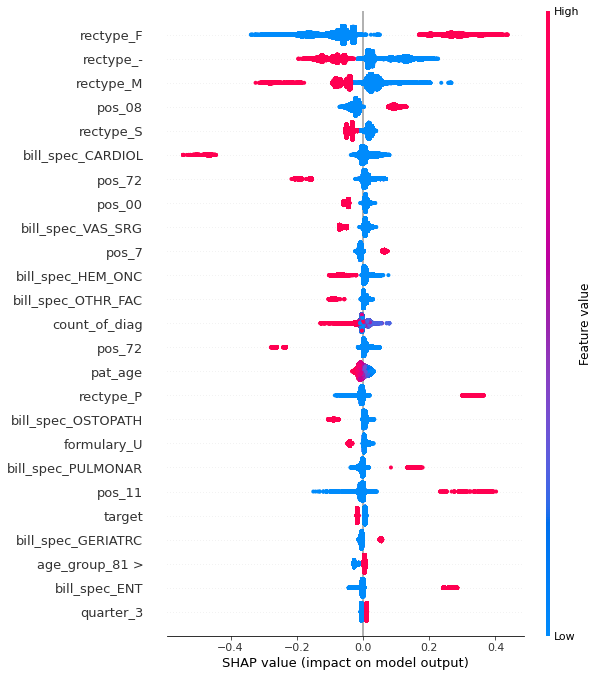

In [22]:
shap.initjs()
shap.summary_plot(shap_values, X_test_array, feature_names=df_train.columns, max_display=25,)

## SHAP for Sample index[1]

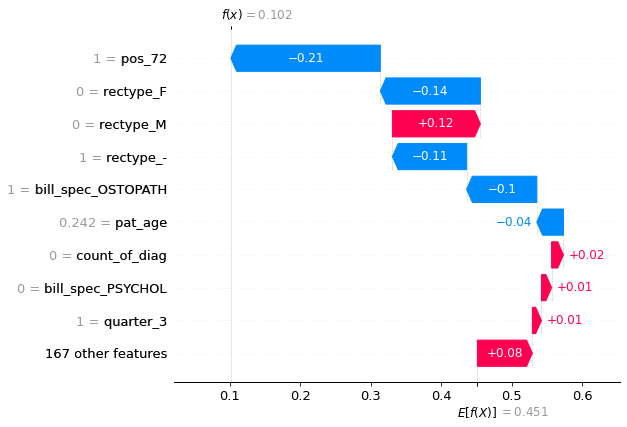

In [23]:
shap.initjs()
wf_explainer = shap.Explainer(model, SHAP_X_test, algorithm="linear", feature_names=df_train.columns)
wf_shap_values = wf_explainer(SHAP_X_test)

shap.plots.waterfall(wf_shap_values[1], max_display=10)

In [24]:
shap.initjs()
cols = df_train.columns
cols = cols[:176]
cols

shap.initjs()
ind = 1
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=cols, contribution_threshold=0.05
)

Visualization omitted, Javascript library not loaded! 
 Have you run `initjs()` in this notebook? If this notebook was from another
 user you must also trust this notebook (File -> Trust notebook). If you are viewing
 this notebook on github the Javascript has been stripped for security. If you are using
 JupyterLab this error is because a JupyterLab extension has not yet been written.

## SHAP for Sample index[500]

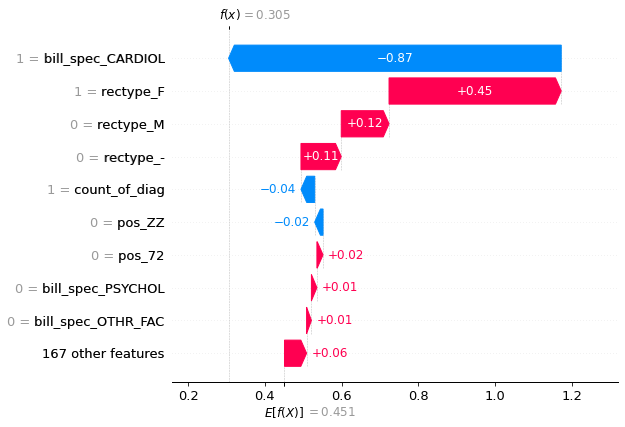

In [25]:
shap.initjs()
wf_explainer = shap.Explainer(model, SHAP_X_test, algorithm="linear", feature_names=df_train.columns)
wf_shap_values = wf_explainer(SHAP_X_test)

shap.plots.waterfall(wf_shap_values[500], max_display=10)

In [26]:
shap.initjs()
ind = 500
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=cols, contribution_threshold=0.05
)

Visualization omitted, Javascript library not loaded! 
 Have you run `initjs()` in this notebook? If this notebook was from another
 user you must also trust this notebook (File -> Trust notebook). If you are viewing
 this notebook on github the Javascript has been stripped for security. If you are using
 JupyterLab this error is because a JupyterLab extension has not yet been written.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from sklearn.preprocessing import RobustScaler

## Data Loading

In [2]:
DATA_PATH='/data/workspace_files/iqvia_data/clean/model_input.csv'

In [3]:
df_heapdl = pd.read_csv(DATA_PATH,delimiter="|")
df_heapdl.sample(3)

,Unnamed: 0,pat_id,quarter,from_dt,to_dt,is_in_patient,duration,paid_dt,rectype,conf_num,...,pat_state,pat_age,age_group,quan,formulary,pmt_st_cd,paid,copay,dispense_fee,target
22437,22445,0309AAAAAAFDTCCS,1,2015-03-02,2015-03-02,0.0,<7,2015-04-01,A,-,...,MN,37.0,31-40,0.0,-,P,76.64,0.0,0.0,76.64
524820,526381,pb02AAAAAABMNRWP,4,2015-11-06,2015-11-06,0.0,<7,2015-12-06,A,-,...,MS,67.0,61-70,0.0,-,P,120.00,0.0,0.0,120.00
1149356,1152078,s138AAAAAKSGBXPR,3,2015-08-11,2015-08-11,0.0,<7,2015-08-16,P,-,...,IN,50.0,51-60,30.0,Y,P,0.00,0.0,0.0,0.00


In [4]:
df_heapdl['paid_dt'] = df_heapdl['paid_dt'].astype('datetime64[ns]')
start_date = "2015-1-1"
end_date = "2016-12-31"
#test_start_date = "2016-7-1"
#test_end_date = "2016-12-31"

df_heapdl = df_heapdl[(df_heapdl["paid_dt"] >= start_date) & (df_heapdl["paid_dt"] <= end_date) & (df_heapdl["rectype"] != '-')]

In [5]:
df_heapdl.sample(3)

,Unnamed: 0,pat_id,quarter,from_dt,to_dt,is_in_patient,duration,paid_dt,rectype,conf_num,...,pat_state,pat_age,age_group,quan,formulary,pmt_st_cd,paid,copay,dispense_fee,target
255116,255750,a7d3AAAAAAOJSNWQ,1,2016-01-22,2016-01-22,0.0,<7,2016-02-21,A,-,...,CA,47.0,41-50,0.0,-,P,10.74,0.0,0.0,10.74
901032,903175,pg03AAAAAATQYWYR,4,2016-10-20,2016-10-20,0.0,<7,2016-11-19,A,-,...,TX,57.0,51-60,0.0,-,P,5.68,0.0,0.0,5.68
363702,364573,f941AAAAAAIBQBNO,1,2015-03-05,2015-03-05,0.0,<7,2015-04-04,A,-,...,NY,78.0,71-80,0.0,-,P,0.00,4.9,0.0,4.90


In [6]:
df_heapdl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338475 entries, 0 to 1387155
Data columns (total 31 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   Unnamed: 0       1338475 non-null  int64         
 1   pat_id           1338475 non-null  object        
 2   quarter          1338475 non-null  int64         
 3   from_dt          1338475 non-null  object        
 4   to_dt            1338475 non-null  object        
 5   is_in_patient    1338475 non-null  float64       
 6   duration         1338475 non-null  object        
 7   paid_dt          1338475 non-null  datetime64[ns]
 8   rectype          1338475 non-null  object        
 9   conf_num         1338475 non-null  object        
 10  icdprc1          1338475 non-null  object        
 11  diag_admit       1338475 non-null  object        
 12  diag1            1338475 non-null  object        
 13  count_of_diag    1338475 non-null  int64         
 14  pr

In [7]:
#see: https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [8]:
df_heapdl = remove_outlier(df_heapdl,"target")
df_heapdl = remove_outlier(df_heapdl,"pat_age")

### Categorical Features

In [9]:
def getCategoryEmbeddings(dataset):
    cat_feature_col=["quarter","duration","rectype","pos","der_sex","age_group","is_in_patient","bill_spec","formulary","proc_cde","diag_admit","ndc"]
    temporal_col = ["paid_dt"]
    for feature in cat_feature_col:
        dataset[feature] = dataset[feature].astype("str")

    lbl_encoders={}
    for feature in cat_feature_col:
        #print(feature)
        #print(f"Generating Label Encoder for: {feature }")
        lbl_encoders[feature]=LabelEncoder()
        dataset[feature]=lbl_encoders[feature].fit_transform(dataset[feature])
    
    #
    #cat_features_df=np.stack([dataset['quarter'],dataset['duration'],dataset['rectype'],dataset['bill_spec'],dataset['pos'], dataset['der_sex'],dataset['age_group']],1)
    cat_features_df =np.stack([dataset[i] for i in cat_feature_col],axis=1)
    #print(f"Category stacked {cat_features_df }")
    
    cat_features_tensor=torch.tensor(cat_features_df,dtype=torch.int64)
    #print(f"Ccat_features_tensor {cat_features_tensor }")
    cat_dims=[len(dataset[col].unique()) for col in cat_feature_col]
    
    embedding_dimemsions= [(x, min(50, (x + 1) // 2)) for x in cat_dims]
    #print(f"Embedding Dim: {embedding_dimemsions}")

    embed_representation = nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dimemsions])

   
    embedding_val=[]
    for i,e in enumerate(embed_representation):
        embedding_val.append(e(cat_features_tensor[:,i]))
    dataset_cat_embedding = torch.cat(embedding_val, 1)
    #print(f"Embedding dataset_cat_embedding: {dataset_cat_embedding.shape}")

    return cat_features_tensor, embedding_dimemsions

In [10]:
def getContinous(dataset):
    cont_feature_col = ["pat_age","count_of_diag","count_of_icdprc"]
    #scaler = QuantileTransformer(n_quantiles=10, random_state=0)
    cont_scaler = RobustScaler()
    #scaler = MinMaxScaler(feature_range=(0, 1))
    for feature in cont_feature_col:
        #dataset[feature].fillna(0.001)
        dataset[feature] = dataset[feature].astype("float")
        dataset[feature] = cont_scaler.fit_transform(dataset[feature].values.reshape(-1,1))
    cont_values_df =np.stack([dataset[i] for i in cont_feature_col],axis=1)
    cont_values=torch.tensor(cont_values_df,dtype=torch.float)
    #print(f"Continuos Values: {cont_values}")
    return cont_values, len(cont_feature_col)

def getTarget(dataset):
    
    target_scaler = RobustScaler()
    
    out_feature_col="target"
    
    dataset[out_feature_col] = dataset[out_feature_col].astype("float")
    dataset[out_feature_col] = target_scaler.fit_transform(dataset[out_feature_col].values.reshape(-1,1))
    
    y=torch.tensor(dataset[out_feature_col].values,dtype=torch.float).reshape(-1,1)
    #print(f"Target Y:{y}")
    return y, target_scaler

    
def claims_train_test_split(dataset, batch_len=135000, split_ratio=0.2):
    #Split Data and store dataframes
    batch_size=batch_len
    #batch_size=135000
    test_size=int(batch_size*split_ratio)
    print(f"test_size: {test_size}")

    dataset_df_train = dataset[:batch_size-test_size]
    dataset_df_val = dataset[batch_size-test_size:batch_size]    
    #
    
    # Fuctions for getting Embedding, Continuos values and Target
    dataset_cat_features, embedding_dims = getCategoryEmbeddings(dataset)
    dataset_cont_values, dataset_cont_count = getContinous(dataset)
    dataset_target, target_scaler = getTarget(dataset)


    # Categorical Tensors
    dataset_categorical=dataset_cat_features[:batch_size-test_size]
    dataset_val_categorical=dataset_cat_features[batch_size-test_size:batch_size]


    
    
    #Continuos Tensors
    dataset_cont=dataset_cont_values[:batch_size-test_size]
    dataset_val_cont=dataset_cont_values[batch_size-test_size:batch_size]

    #Target Tensors
    dataset_y_train=dataset_target[:batch_size-test_size]
    dataset_y_val=dataset_target[batch_size-test_size:batch_size]

    
    

    return dataset_df_train, dataset_df_val, dataset_categorical, dataset_val_categorical, dataset_cont, dataset_val_cont, dataset_y_train, dataset_y_val, target_scaler, embedding_dims, dataset_cont_count

# Prepare Training & Validation Data

In [11]:


batch_length = len(df_heapdl.index)
split_ratio = 0.2
X_df_train, X_df_val, X_train_cat, X_val_cat, X_train_cont, X_val_cont, Y_train, Y_val, Y_scaler, heap_dl_embedding_dims, heap_dl_cont_count = claims_train_test_split(df_heapdl, batch_length,split_ratio)

test_size: 233129


In [12]:
X_df_val

,Unnamed: 0,pat_id,quarter,from_dt,to_dt,is_in_patient,duration,paid_dt,rectype,conf_num,...,pat_state,pat_age,age_group,quan,formulary,pmt_st_cd,paid,copay,dispense_fee,target
1097328,1100038,s123AAAAAHPBMGJN,1,2015-02-25,2015-02-25,0.0,<7,2015-03-27,A,-,...,PA,63.0,61-70,0.0,-,P,0.00,0.0,0.0,0.00
1097329,1100039,s123AAAAAHPBMGJN,1,2015-02-25,2015-02-25,0.0,<7,2015-03-27,M,-,...,PA,63.0,61-70,0.0,-,P,66.76,0.0,0.0,66.76
1097330,1100040,s123AAAAAHPBMGJN,1,2015-03-24,2015-03-24,0.0,<7,2015-04-23,A,-,...,PA,63.0,61-70,0.0,-,P,137.30,0.0,0.0,137.30
1097331,1100041,s123AAAAAHPBMGJN,1,2015-03-24,2015-03-24,0.0,<7,2015-04-23,A,-,...,PA,63.0,61-70,0.0,-,P,3.46,0.0,0.0,3.46
1097332,1100042,s123AAAAAHPBMGJN,1,2015-03-24,2015-03-24,0.0,<7,2015-04-23,A,-,...,PA,63.0,61-70,0.0,-,P,42.52,0.0,0.0,42.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387148,1403387,s153AAAAAQWAQSGZ,4,2016-11-02,2016-11-02,0.0,<7,2016-11-07,P,-,...,WA,53.0,51-60,4.0,Y,P,70.29,0.0,0.0,70.29
1387149,1403388,s153AAAAAQWAQSGZ,4,2016-11-08,2016-11-08,0.0,<7,2016-12-08,M,-,...,WA,53.0,51-60,0.0,-,P,102.00,0.0,0.0,102.00
1387152,1403391,s153AAAAAQWAQSGZ,4,2016-12-05,2016-12-05,0.0,<7,2016-12-10,P,-,...,WA,53.0,51-60,7.0,Y,P,3.79,0.0,0.0,3.79
1387153,1403392,s153AAAAAQWAQSGZ,4,2016-12-05,2016-12-05,0.0,<7,2016-12-10,P,-,...,WA,53.0,51-60,4.0,Y,P,70.29,0.0,0.0,70.29


In [13]:
X_train_cat.shape, X_val_cat.shape, X_train_cont.shape, X_val_cont.shape, Y_train.shape, Y_val.shape

(torch.Size([932516, 12]),
 torch.Size([233129, 12]),
 torch.Size([932516, 3]),
 torch.Size([233129, 3]),
 torch.Size([932516, 1]),
 torch.Size([233129, 1]))

In [14]:
len(X_train_cat),len(X_val_cat),len(X_train_cont),len(X_val_cont),len(Y_train),len(Y_val)

(932516, 233129, 932516, 233129, 932516, 233129)

In [15]:
heap_dl_embedding_dims

[(4, 2),
 (5, 3),
 (5, 3),
 (43, 22),
 (3, 2),
 (10, 5),
 (2, 1),
 (64, 32),
 (5, 3),
 (5375, 50),
 (850, 50),
 (12321, 50)]

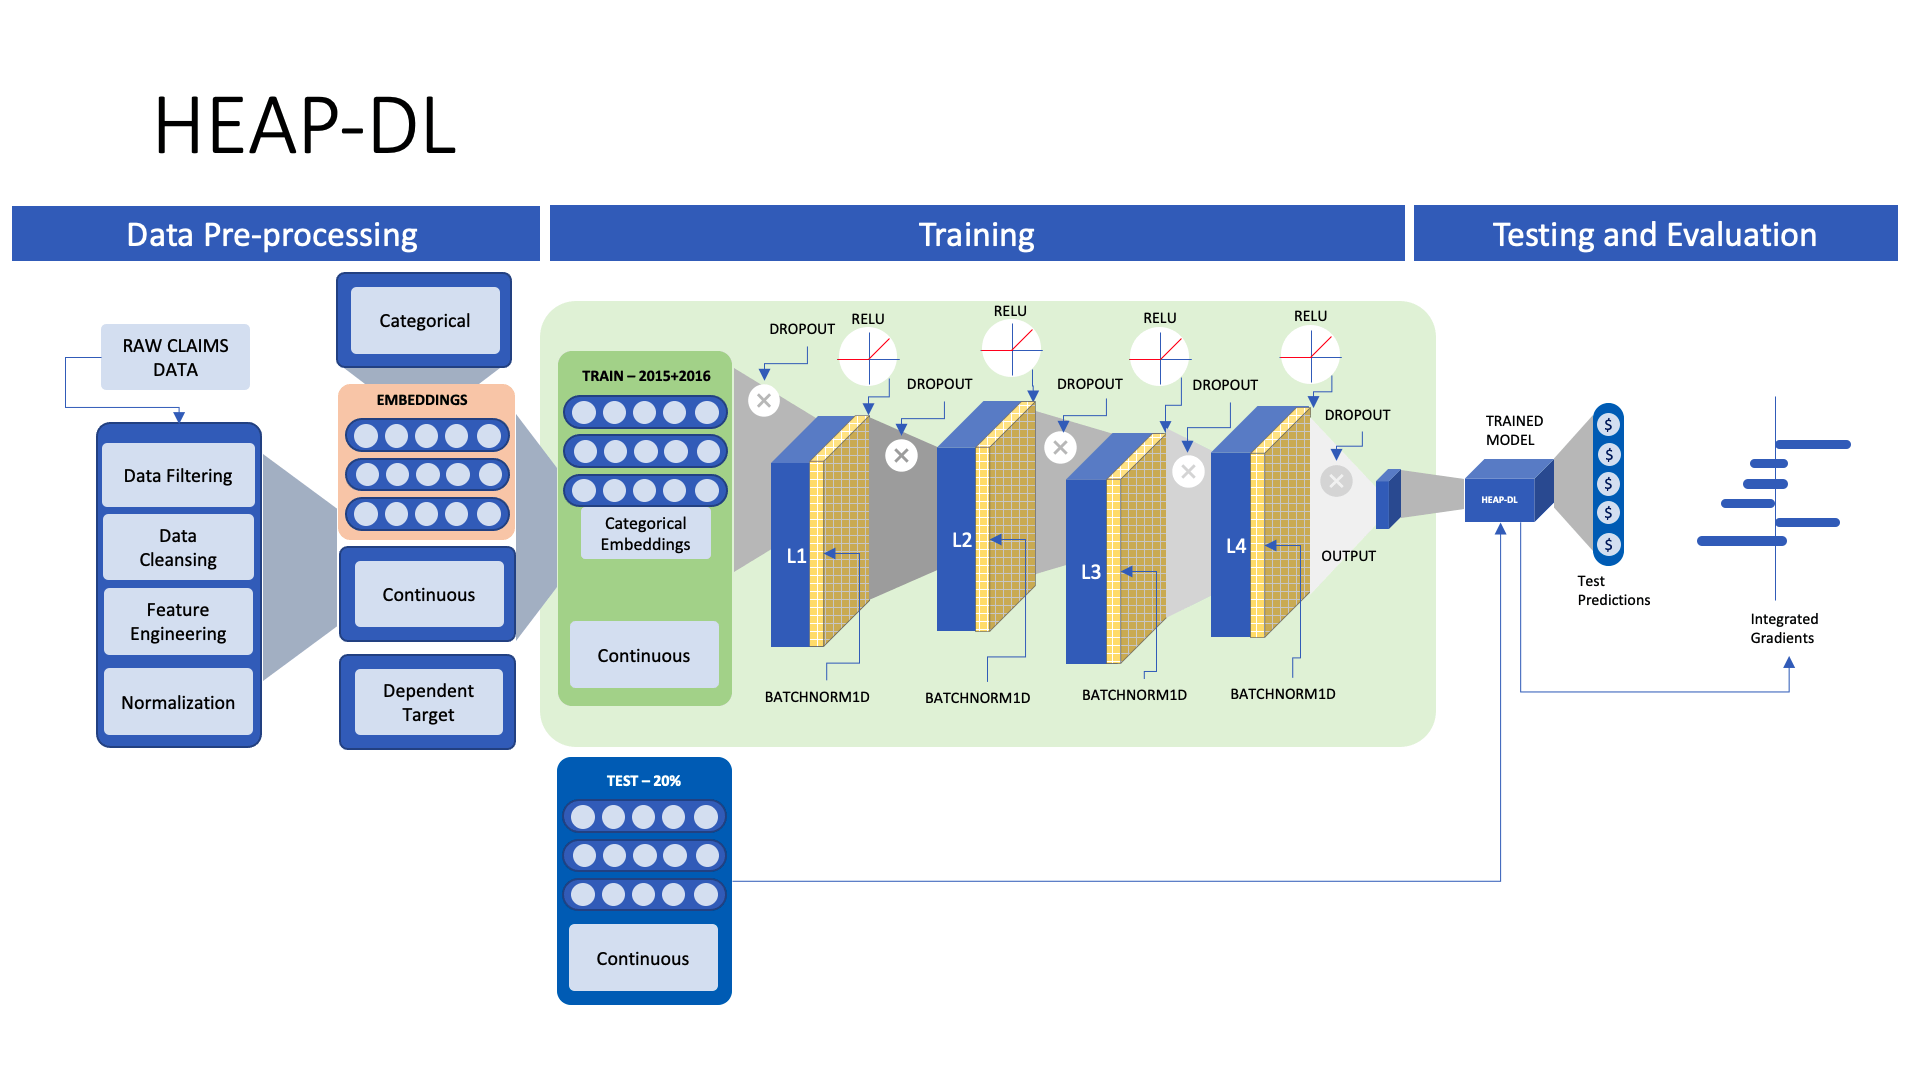

In [16]:
from IPython.display import Image
Image(filename='img/heap-dl-model.png')


HEAP-DL has four hidden layers each having 50 neurons each. All layers uses a ReLU-activation step, BatchNorm1D (https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/)  also acts as a regularization step and a dropout rate of 0.2 during training. The categorical features were converted into feature embeddings and passed to the layer and there is a drop out of 0.2 applied to the embedding. The predicted target variable is a transformed sum value of paid, dispense and copay. The model was trained for 200 epochs and RMSE score, Target columns a derived numerical values which is  a sum of claims paid amount, pharmacy dispense_fee & patient copay since these are assumed to be the direct cost for the payer as per the IQVIA Pharmetrics data dictionary and user guide.

### Create a Feed Forward Neural Network

In [17]:

import torch
import torch.nn as nn


class HEAPDL_Model(nn.Module):

    def __init__(self, embedding_dim, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dim])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont, affine=True, momentum=0.1, eps=1e-05, track_running_stats=True)
        
        
        layerlist = []
        n_emb = sum((out for inp,out in embedding_dim))
        n_in = n_emb + n_cont
        
        for i in layers:
            #Linear Layer
            layerlist.append(nn.Linear(n_in,i)) 
            
            #ReLU Activation Layer
            layerlist.append(nn.ReLU(inplace=True))

            #BatchNorm 1D Layer - Regularization

            layerlist.append(nn.BatchNorm1d(i, affine=True, momentum=0.1, eps=1e-05, track_running_stats=True))
            
            
            #DropOut Layer
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

### Model Initialization

In [18]:

#Inputs heap_dl_embedding_dims - HEAP DL category features Embeddings
#Inputs heap_dl_cont_coun - HEAP DL count of continuos features

#Dropout 0.1 and BatchNorm1D applied for regularization and model overfitting

model=HEAPDL_Model(heap_dl_embedding_dims,heap_dl_cont_count,1,[50,50,50,50],p=0.2)

### HEAP-DL Model Summary

In [19]:
model

HEAPDL_Model(
  (embeds): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(5, 3)
    (2): Embedding(5, 3)
    (3): Embedding(43, 22)
    (4): Embedding(3, 2)
    (5): Embedding(10, 5)
    (6): Embedding(2, 1)
    (7): Embedding(64, 32)
    (8): Embedding(5, 3)
    (9): Embedding(5375, 50)
    (10): Embedding(850, 50)
    (11): Embedding(12321, 50)
  )
  (emb_drop): Dropout(p=0.2, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=226, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=50, out_features=5

### Loss Function and Optimizer

In [20]:
#Settings based om wandb.ai Model Experiments
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.02)

In [21]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [22]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [23]:
#Uncomment if using GPU Kernel in Datalore
!pip install torch==1.8.1+cu102 torchvision==0.9.1+cu102 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html -qq

### HEAP-DL Model Training

In [24]:
# Set Model in Training Mode
torch.manual_seed(100)
model.to(device)
model.train()
epochs=100
final_losses=[]
for i in range(epochs):
    i=i+1
    y_pred=model(X_train_cat.to(device),X_train_cont.to(device))
    loss=torch.sqrt(loss_function(y_pred.to(device),Y_train.to(device))) ### RMSE
    final_losses.append(loss)
    if i%10==1:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch number: 1 and the loss : 1.1789880990982056
Epoch number: 11 and the loss : 0.8320707678794861
Epoch number: 21 and the loss : 0.7652077078819275
Epoch number: 31 and the loss : 0.7354652881622314
Epoch number: 41 and the loss : 0.7036353349685669
Epoch number: 51 and the loss : 0.6725979447364807
Epoch number: 61 and the loss : 0.6600614190101624
Epoch number: 71 and the loss : 0.6522604823112488
Epoch number: 81 and the loss : 0.6473663449287415
Epoch number: 91 and the loss : 0.6439136862754822


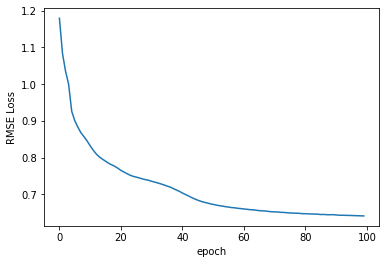

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(epochs), final_losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

#### Validate the Test Data
HEAP-DL model acheived an **RMSE score of 0.766**

In [26]:
# Set Model in Evaluate Mode
torch.manual_seed(100)
y_pred=""
model.eval()
with torch.no_grad():
    y_pred=model(X_val_cat.to(device),X_val_cont.to(device))
    loss=torch.sqrt(loss_function(y_pred.to(device),Y_val.to(device)))
print('RMSE: {}'.format(loss))

RMSE: 0.7766178250312805


### Test Prediction and Difference for Visualization

In [27]:
#X_df_train, X_df_val, X_train_cat, X_val_cat, X_train_cont, X_val_cont, Y_train, Y_val, Y_scalar,
report_df = X_df_val.copy()

data_verify=pd.DataFrame(Y_val.tolist(),columns=["Test"])
data_predicted=pd.DataFrame(y_pred.tolist(),columns=["Prediction"])
final_output=pd.concat([data_verify,data_predicted],axis=1)

report_df['Test'] = data_verify["Test"].values
report_df['Prediction'] = data_predicted["Prediction"].values


report_df['Prediction'] = Y_scaler.inverse_transform(report_df['Prediction'].values.reshape(-1,1)).round(2)
#report_df['target'] = Y_scaler.inverse_transform(report_df['target'].values.reshape(-1,1)).round(2)
report_df['Test'] = Y_scaler.inverse_transform(report_df['Test'].values.reshape(-1,1)).round(2)
report_df['Difference']=(report_df['Test']-report_df['Prediction']).round(2)

report_df.describe()

,Unnamed: 0,quarter,is_in_patient,count_of_diag,count_of_icdprc,der_yob,pat_age,quan,paid,copay,dispense_fee,target,Test,Prediction,Difference
count,2.331290e+05,233129.000000,233129.000000,233129.000000,233129.0,233129.000000,233129.000000,233129.000000,233129.000000,233129.0,233129.0,233129.000000,233129.000000,233129.000000,233129.000000
mean,1.248255e+06,2.492800,0.000665,1.409524,0.0,1967.405664,39.885227,17.491105,28.184016,0.0,0.0,28.184016,28.184016,26.133468,2.050548
std,8.787777e+04,1.119874,0.025777,1.376058,0.0,127.429786,18.899463,76.029679,36.510768,0.0,0.0,36.510768,36.510768,22.966172,29.050951
min,1.100038e+06,1.000000,0.000000,0.000000,0.0,0.000000,-1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.480000,-121.350000
25%,1.170316e+06,1.000000,0.000000,0.000000,0.0,1960.000000,26.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,7.540000,-9.620000
50%,1.247409e+06,2.000000,0.000000,1.000000,0.0,1972.000000,43.000000,0.000000,12.000000,0.0,0.0,12.000000,12.000000,18.400000,-2.420000
75%,1.324065e+06,3.000000,0.000000,2.000000,0.0,1989.000000,55.000000,28.000000,42.730000,0.0,0.0,42.730000,42.730000,39.410000,10.620000
max,1.403393e+06,4.000000,1.000000,4.000000,0.0,2017.000000,81.000000,4000.000000,145.900000,0.0,0.0,145.900000,145.900000,125.180000,140.610000


In [28]:
report_df

,Unnamed: 0,pat_id,quarter,from_dt,to_dt,is_in_patient,duration,paid_dt,rectype,conf_num,...,quan,formulary,pmt_st_cd,paid,copay,dispense_fee,target,Test,Prediction,Difference
1097328,1100038,s123AAAAAHPBMGJN,1,2015-02-25,2015-02-25,0.0,<7,2015-03-27,A,-,...,0.0,-,P,0.00,0.0,0.0,0.00,0.00,6.14,-6.14
1097329,1100039,s123AAAAAHPBMGJN,1,2015-02-25,2015-02-25,0.0,<7,2015-03-27,M,-,...,0.0,-,P,66.76,0.0,0.0,66.76,66.76,63.84,2.92
1097330,1100040,s123AAAAAHPBMGJN,1,2015-03-24,2015-03-24,0.0,<7,2015-04-23,A,-,...,0.0,-,P,137.30,0.0,0.0,137.30,137.30,37.79,99.51
1097331,1100041,s123AAAAAHPBMGJN,1,2015-03-24,2015-03-24,0.0,<7,2015-04-23,A,-,...,0.0,-,P,3.46,0.0,0.0,3.46,3.46,6.45,-2.99
1097332,1100042,s123AAAAAHPBMGJN,1,2015-03-24,2015-03-24,0.0,<7,2015-04-23,A,-,...,0.0,-,P,42.52,0.0,0.0,42.52,42.52,53.10,-10.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387148,1403387,s153AAAAAQWAQSGZ,4,2016-11-02,2016-11-02,0.0,<7,2016-11-07,P,-,...,4.0,Y,P,70.29,0.0,0.0,70.29,70.29,39.23,31.06
1387149,1403388,s153AAAAAQWAQSGZ,4,2016-11-08,2016-11-08,0.0,<7,2016-12-08,M,-,...,0.0,-,P,102.00,0.0,0.0,102.00,102.00,33.40,68.60
1387152,1403391,s153AAAAAQWAQSGZ,4,2016-12-05,2016-12-05,0.0,<7,2016-12-10,P,-,...,7.0,Y,P,3.79,0.0,0.0,3.79,3.79,25.49,-21.70
1387153,1403392,s153AAAAAQWAQSGZ,4,2016-12-05,2016-12-05,0.0,<7,2016-12-10,P,-,...,4.0,Y,P,70.29,0.0,0.0,70.29,70.29,39.23,31.06


In [29]:
report_df.to_csv("/data/workspace_files/iqvia_data/clean/val_model_output.csv")

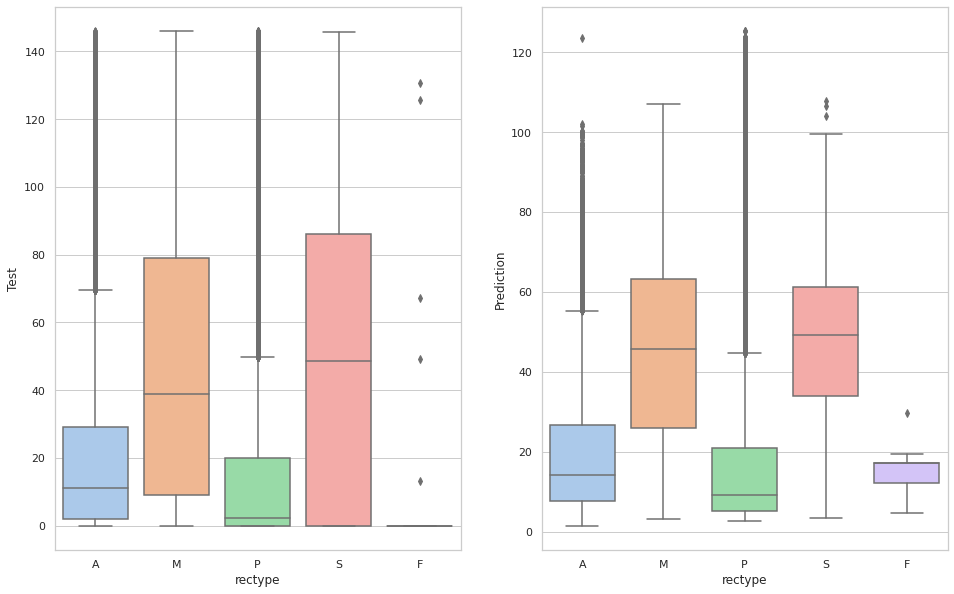

In [30]:
X_df_val = report_df

sns.set(style="whitegrid", palette="pastel", color_codes=True)
fig, axes = plt.subplots(1, 2, figsize=(16,10))
sns.boxplot(x=X_df_val["rectype"], y=X_df_val["Test"], orient='v', ax=axes[0])
sns.boxplot(X_df_val["rectype"], y=X_df_val["Prediction"], orient='v', ax=axes[1])
plt.show()

KeyError: KeyError: 'U'

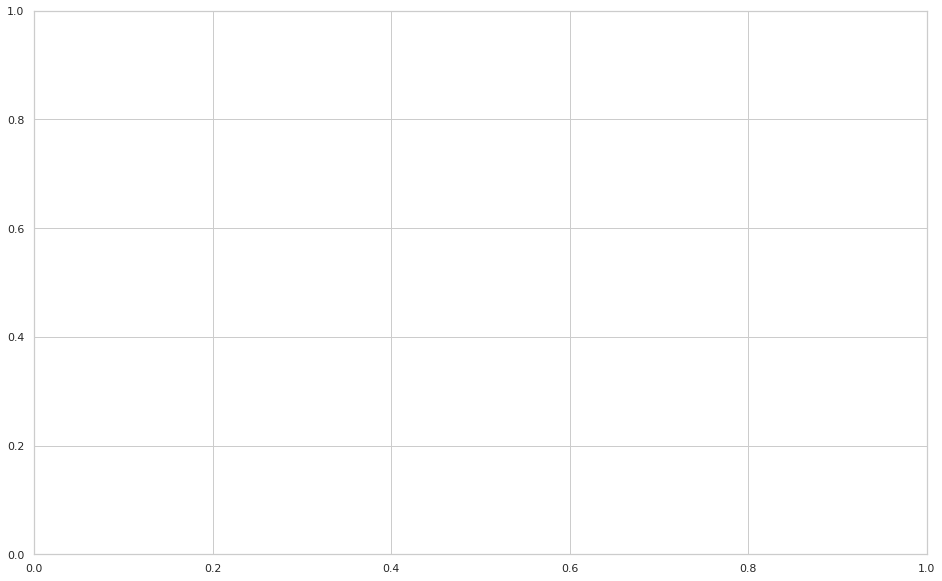

In [31]:

fig, axes = plt.subplots(1, figsize=(16, 10))
sns.boxplot(x="rectype", y="Prediction", data=X_df_val, hue="der_sex", palette={"F":"pink", "M":"b"}, showcaps=False)
sns.despine(bottom=True, offset=15)
plt.show()

KeyError: KeyError: 'U'

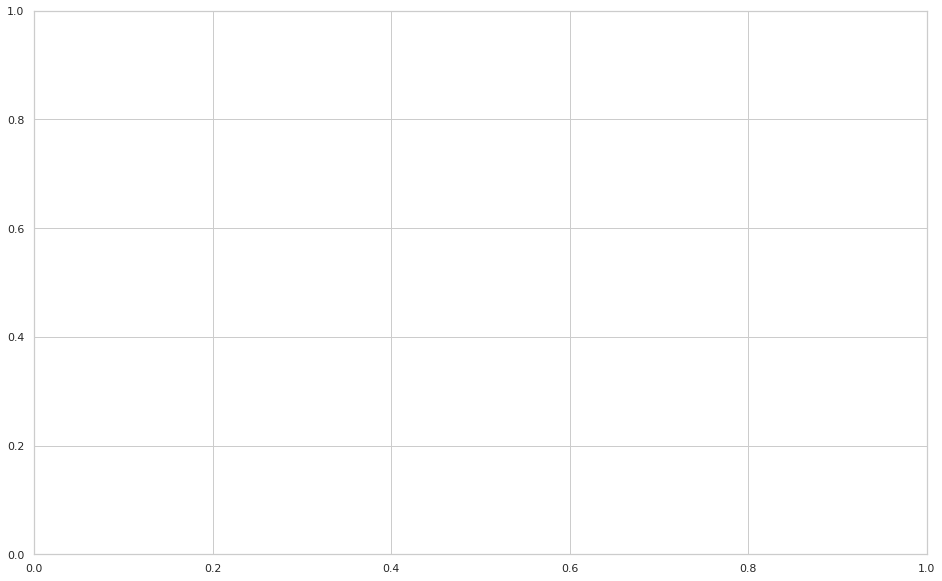

In [32]:
fig, axes = plt.subplots(1, figsize=(16, 10))

sns.violinplot(x="rectype", y="Prediction", split=True, inner="points", data=X_df_val, hue="der_sex", palette={"F":"pink", "M":"b"}, showcaps=False)
sns.despine(bottom=True, offset=15)
plt.show()

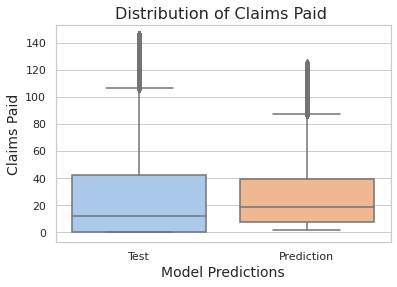

In [33]:
df_report = pd.DataFrame(data=X_df_val, columns=["Test","Prediction"])
boxplot = sns.boxplot(x="variable", y="value", data=pd.melt(df_report), order=["Test","Prediction"])
boxplot.axes.set_title("Distribution of Claims Paid ", fontsize=16)
boxplot.set_xlabel("Model Predictions", fontsize=14)
boxplot.set_ylabel("Claims Paid", fontsize=14)
plt.show()

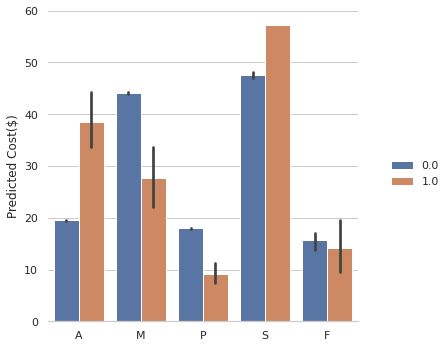

In [34]:
import seaborn as sns
sns.set_theme(style="whitegrid")


g = sns.catplot(
    data=X_df_val, kind="bar",
    x="rectype", y="Prediction", hue="is_in_patient")
    
g.despine(left=True)
g.set_axis_labels("", "Predicted Cost($)")
g.legend.set_title("")

### Saving the Model with State Dictionaries

In [35]:
torch.save(model.state_dict(),'/data/workspace_files/model/heapdl-baseline.pt')

### Loading model and using prior defined Embedding dimensions

In [38]:

split_ratio = 0.2
IG_X_df_train, IG_X_df_val, IG_X_train_cat, IG_X_val_cat, IG_X_train_cont, IG_X_val_cont, IG_Y_train, IG_Y_val, IG_Y_scaler, heap_dl_embedding_dims, heap_dl_cont_count = claims_train_test_split(df_heapdl, batch_length,split_ratio)

test_size: 233129


In [39]:
#X_df_train, X_df_val, X_train_cat, X_val_cat, X_train_cont, X_val_cont, Y_train, Y_val, Y_scalar,
embs_size=[(4, 2),(5, 3),(5, 3),(43, 22),(3, 2),(10, 5),(2, 1),(64, 32),(5, 3),(5375, 50),(850, 50),(12321, 50)]

model1= HEAPDL_Model(embs_size,heap_dl_cont_count,1,[50,50,50,50],p=0.1)
model1.load_state_dict(torch.load('/data/workspace_files/model/heapdl-baseline.pt'))

<All keys matched successfully>

In [40]:
model1

HEAPDL_Model(
  (embeds): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(5, 3)
    (2): Embedding(5, 3)
    (3): Embedding(43, 22)
    (4): Embedding(3, 2)
    (5): Embedding(10, 5)
    (6): Embedding(2, 1)
    (7): Embedding(64, 32)
    (8): Embedding(5, 3)
    (9): Embedding(5375, 50)
    (10): Embedding(850, 50)
    (11): Embedding(12321, 50)
  )
  (emb_drop): Dropout(p=0.1, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=226, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=50, out_features=5

# Captum Integrated Gradients
Reference: https://captum.ai/docs/extension/integrated_gradients
Original Paper: https://arxiv.org/pdf/1703.01365.pdf

Integrated gradients is a simple axiomatic attribution method used for augmenting accuracy metrics, model debugging and feature or rule extraction.

Captum provides an implementation of integrated gradients that can be used with any PyTorch model. In this section of we implemented the Layer integrated gradients for output predictions from teh last hidden layer before teh ouput to evaluate teh feature importance. 

In [41]:
# imports from captum library
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients

In [42]:
lig = LayerIntegratedGradients(model1, model1.emb_drop)

In [43]:
attributions_start, delta_start = lig.attribute(inputs=(X_val_cat[:50],X_val_cont[:50]), baselines=(X_val_cat[:50],X_val_cont[:50]), return_convergence_delta=True)

In [44]:
ig_attr_test_sum = attributions_start.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
ig_attr_test_norm_sum.shape

(223,)

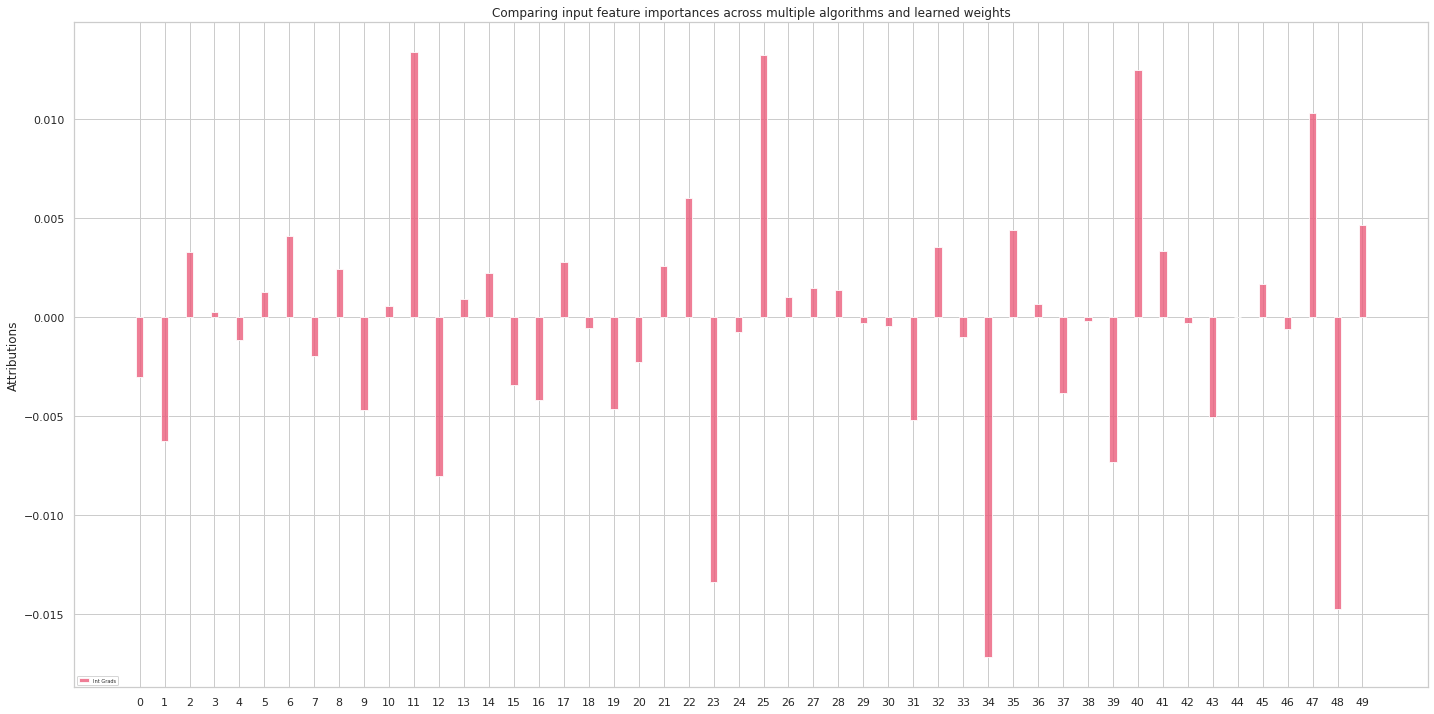

In [57]:
x_axis_data = np.arange(69)
#x_axis_data_labels = list(map(lambda idx: attributions_start[:,idx], x_axis_data))

ig_attr_test_sum = attributions_start.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
weights = model.layers[4].weight[0].cpu()
lin_weight = weights
y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight.detach().numpy(), ord=1)

width = 0.3
legends = ['Int Grads']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 9
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data[:50], ig_attr_test_norm_sum[:50], width, align='center', alpha=0.8, color='#eb5e7c')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data[:50])
#ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

# Final Reports 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import plotly.express as px

warnings.filterwarnings('ignore')

In [2]:
DATA_PATH='/data/workspace_files/iqvia_data/clean/val_model_output.csv'
df = pd.read_csv(DATA_PATH,delimiter=",")
df

,Unnamed: 0,Unnamed: 0.1,pat_id,quarter,from_dt,to_dt,is_in_patient,duration,paid_dt,rectype,...,quan,formulary,pmt_st_cd,paid,copay,dispense_fee,target,Test,Prediction,Difference
0,1239745,1247410,s142AAAAALQEMRQV,3,2015-08-20,2015-08-20,0.0,<7,2015-08-25,P,...,10.0,Y,P,141.03,0.0,0.0,141.03,141.03,119.94,21.09
1,1239746,1247411,s142AAAAALQEMRQV,3,2015-09-14,2015-09-14,0.0,<7,2015-10-14,M,...,0.0,-,P,84.38,0.0,0.0,84.38,84.38,49.59,34.79
2,1239747,1247412,s142AAAAALQEMRQV,3,2015-09-14,2015-09-14,0.0,<7,2015-09-19,P,...,75.0,Y,P,53.13,0.0,0.0,53.13,53.13,20.35,32.78
3,1239748,1247413,s142AAAAALQEMRQV,3,2015-09-14,2015-09-14,0.0,<7,2015-09-19,P,...,10.0,Y,P,141.03,0.0,0.0,141.03,141.03,119.94,21.09
4,1239749,1247414,s142AAAAALQEMRQV,3,2015-09-14,2015-09-14,0.0,<7,2015-09-19,P,...,21.0,Y,P,0.00,0.0,0.0,0.00,0.00,4.98,-4.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116559,1387148,1403387,s153AAAAAQWAQSGZ,4,2016-11-02,2016-11-02,0.0,<7,2016-11-07,P,...,4.0,Y,P,70.29,0.0,0.0,70.29,70.29,30.38,39.91
116560,1387149,1403388,s153AAAAAQWAQSGZ,4,2016-11-08,2016-11-08,0.0,<7,2016-12-08,M,...,0.0,-,P,102.00,0.0,0.0,102.00,102.00,40.47,61.53
116561,1387152,1403391,s153AAAAAQWAQSGZ,4,2016-12-05,2016-12-05,0.0,<7,2016-12-10,P,...,7.0,Y,P,3.79,0.0,0.0,3.79,3.79,34.68,-30.89
116562,1387153,1403392,s153AAAAAQWAQSGZ,4,2016-12-05,2016-12-05,0.0,<7,2016-12-10,P,...,4.0,Y,P,70.29,0.0,0.0,70.29,70.29,30.38,39.91


In [3]:
def rectype(df):
    if(df["rectype"] == "M"):
        return "Management"
    elif(df["rectype"] == "S"):
        return "Surgical"
    elif(df["rectype"] == "F"):
        return "Facility"
    elif(df["rectype"] == "A"):
        return "Ancillary"
    elif(df["rectype"] == "P"):
        return "Pharmaceutical"
    elif(df["rectype"] == "J"):
        return "Other"

In [4]:
df = df[['is_in_patient', 'duration', 'to_dt', 'paid_dt', 'rectype', 'count_of_diag'
    ,'count_of_icdprc', 'bill_spec', 'pos', 'der_sex', 'pat_state', 'pat_age', 'age_group','formulary'
    , 'target', 'Test', 'Prediction', 'Difference', 'pat_id']]
df["rectype_desc"] = df.apply(rectype, axis=1)
df["year_quarter"] = pd.to_datetime(df["to_dt"]).dt.to_period("Q")

group_by_columns = ['is_in_patient', 'duration', 'paid_dt', 'rectype', 'count_of_diag'
    ,'count_of_icdprc', 'bill_spec', 'pos', 'der_sex', 'pat_state', 'pat_age', 'age_group','formulary'
    , 'target', 'Test', 'Prediction', 'Difference']

df

# By Rectype by Age Group
# By Age Group
# Geo Map by State
# Line CHart



,is_in_patient,duration,to_dt,paid_dt,rectype,count_of_diag,count_of_icdprc,bill_spec,pos,der_sex,...,pat_age,age_group,formulary,target,Test,Prediction,Difference,pat_id,rectype_desc,year_quarter
0,0.0,<7,2015-08-20,2015-08-25,P,0,0,-,1,M,...,50.0,51-60,Y,141.03,141.03,119.94,21.09,s142AAAAALQEMRQV,Pharmaceutical,2015Q3
1,0.0,<7,2015-09-14,2015-10-14,M,3,0,GP_FP,11,M,...,50.0,51-60,-,84.38,84.38,49.59,34.79,s142AAAAALQEMRQV,Management,2015Q3
2,0.0,<7,2015-09-14,2015-09-19,P,0,0,-,1,M,...,50.0,51-60,Y,53.13,53.13,20.35,32.78,s142AAAAALQEMRQV,Pharmaceutical,2015Q3
3,0.0,<7,2015-09-14,2015-09-19,P,0,0,-,1,M,...,50.0,51-60,Y,141.03,141.03,119.94,21.09,s142AAAAALQEMRQV,Pharmaceutical,2015Q3
4,0.0,<7,2015-09-14,2015-09-19,P,0,0,-,1,M,...,50.0,51-60,Y,0.00,0.00,4.98,-4.98,s142AAAAALQEMRQV,Pharmaceutical,2015Q3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116559,0.0,<7,2016-11-02,2016-11-07,P,0,0,-,1,M,...,53.0,51-60,Y,70.29,70.29,30.38,39.91,s153AAAAAQWAQSGZ,Pharmaceutical,2016Q4
116560,0.0,<7,2016-11-08,2016-12-08,M,2,0,OTHR_SPC,22,M,...,53.0,51-60,-,102.00,102.00,40.47,61.53,s153AAAAAQWAQSGZ,Management,2016Q4
116561,0.0,<7,2016-12-05,2016-12-10,P,0,0,-,1,M,...,53.0,51-60,Y,3.79,3.79,34.68,-30.89,s153AAAAAQWAQSGZ,Pharmaceutical,2016Q4
116562,0.0,<7,2016-12-05,2016-12-10,P,0,0,-,1,M,...,53.0,51-60,Y,70.29,70.29,30.38,39.91,s153AAAAAQWAQSGZ,Pharmaceutical,2016Q4


In [5]:
treatment_features =  ["is_in_patient", "duration", "count_of_diag", "count_of_icdprc"]
service_features = ["rectype_desc", "bill_spec"]
demo_features = ["der_sex", "age_group", "pat_state"]

In [6]:
df["demo_features"] = df[demo_features].astype(str).agg('-'.join, axis=1)
df["treatment_features"] = df[treatment_features].astype(str).agg('-'.join, axis=1)
df["service_features"] = df[service_features].astype(str).agg('-'.join, axis=1)

In [7]:
import plotly.io as pio

fig = px.bar(data_frame=df.groupby(["demo_features"]).agg({"target": "sum"}).reset_index().sort_values(by="target",ascending=False)
                 , x="demo_features"
                 , y="target"
             )
fig.show()

Unsupported

In [8]:
fig = px.bar(data_frame=df.groupby(["service_features"]).agg({"target": "mean"}).reset_index().sort_values(by="target",ascending=False)
                 , x="service_features"
                 , y="target"
             )
fig.show()

Unsupported

In [9]:
fig = px.bar(data_frame=df.groupby(["treatment_features"]).agg({"target": "mean"}).reset_index().sort_values(by="target",ascending=False)
                 , x="treatment_features"
                 , y="target"
             )
fig.show()

Unsupported

In [10]:
state_analysis = df.groupby(["pat_state"]).agg({"pat_id": "count"}).reset_index()
fig = px.choropleth(state_analysis, locations=state_analysis["pat_state"], locationmode="USA-states",
 color="pat_id",scope="usa",hover_name="pat_state")
fig.show()

Unsupported

In [11]:
state_analysis = df.groupby(["pat_state"]).agg({"target": "mean"}).reset_index()
fig = px.choropleth(state_analysis, locations=state_analysis["pat_state"], locationmode="USA-states",
 color="target",scope="usa",hover_name="pat_state")
fig.show()

Unsupported

In [12]:
fig = px.bar(data_frame=(df.groupby(["age_group"])
                         .agg({"target": "sum"}).reset_index()
                         .sort_values(by="target",ascending=False))
                 , x="age_group"
                 , y="target"
             )
fig.show()

Unsupported

In [13]:
fig = px.bar(data_frame=df.groupby(["rectype_desc","age_group"]).sum().reset_index().sort_values(by="target", ascending=False)
                 , x="rectype_desc"
                 , y="target"
             , color="age_group"
             )

fig.show()

Unsupported